<p align="left">
<img src="figures/Unipd_1.png"  width="300"/> </p>
<p align="left">

<div align="center"> <h2 align="center"> Dipartimento di Fisica e Astronomia "Galileo Galilei" </h2> </div>
<div align="center"> <h2 align="center"> Master degree in Physics of Data</h2> </div>
<div align="center"> <h2 align="center"> Management of Physics Dataset, module B </h2> </div>
<div align="center"> <h2 align="center"> Theivan Pasupathipillai, Sarvenaz Babakhani, Reza Rajaee, Bahador Amjadi </h2> </div>
<br>
<br>

# Anomaly Detection and Predictive Maintenance for Industrial Devices

## Table of contents:
- [Introduction](#Introduction)
- [Setting Up the Environment](#require)
- [Loading The Data](#intro)
- [Assignments](#assign)
    - [Assignment 1: Anomaly Detection](#anomaly)
        - [Normalizing the Sampling Frequecies](#norm)
        - [Defining an Anomaly Metric](#metric)
        - [Measuring the Correlation](#corr1)
    - [Assignment 2: Anomaly Detection 2](#anomaly2)
    - [Assignment 3: Predictive Maintenace](#predmain) 

- [Conclusion](#conc)

# Introduction

Nowadays, IoT and Big Data allowed retrieving significant benefits from the devices’
data sensors. Typically in the academic world, this means, the possibility to perform
some analysis as time series forecasting, data predictions, and data classification.
Despite this being extremely useful from the research side, from the enterprise point
of view, the necessities are instead to exploit the huge amounts of data generated by
devices, to perform some predictions for Anomaly detection (AD) and Predictive Maintenance
(PM):

• Anomaly detection (also outlier detection) is the identification of rare items, events,
or observations that raise suspicions by differing significantly from the majority of
the data (Wikipedia Anomaly Detection). <br>

• Predictive maintenance techniques are designed to help determine the condition of
in-service equipment to estimate when maintenance should be performed. (Wikipedia
Predictive Maintenance)
In the light of the above, it’s clear, that both AD and PM are extremely important for a
company to identify possible problems on their devices, anomalies during a production
process, perform maintenance before a fault of a device, or reduce the cost of recurrent
maintenance (that is done even if it is not necessary).
The following project is based on real data

## Setting Up the Environment <a class="anchor" id="require"></a>

For this project we carry out the calculation on a distributed system of three virtual machines on cloud veneto managed by Apache Spark. We use one master and three workers with 5GB of RAM each

In [1]:
import findspark
findspark.init('/usr/local/spark')

In [2]:
from pyspark.sql.functions import col, max as max_, min as min_
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.sql.types import DoubleType, FloatType, LongType
from pyspark.sql.functions import *
import pyspark.sql.functions as func
from pyspark.sql.window import Window
import numpy as np
import pandas as pd

In [3]:
import pyspark

In [4]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
            .master("spark://10.67.22.217:7077")\
            .appName("Anomaly Detection")\
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.2.0')\
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')\
            .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
            .config("spark.executor.memory", "5g")\
            .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
            .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
            .config('spark.hadoop.fs.s3a.access.key', '394271557973458ab5cc0d3428de6875')\
            .config('spark.hadoop.fs.s3a.secret.key', '1234d088c2014b85996d6d2f1078607f')\
            .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
            .config("com.amazonaws.sdk.disableCertChecking","true") \
            .getOrCreate()

spark

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.amazonaws#aws-java-sdk added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d2fcbceb-52ec-4045-bc0b-72895600809e;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk;1.11.375 in central
	found com.amazonaws#aws-java-sdk-dlm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-core;1.11.375 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.5 in central
	found org.apache.httpcomponents#httpcore;4.4.9 in central
	found commons-codec#commons-codec;1.10 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.6.7.1 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.6.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.6.7 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in

	found com.amazonaws#aws-java-sdk-codecommit;1.11.375 in central
	found com.amazonaws#aws-java-sdk-devicefarm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-elasticsearch;1.11.375 in central
	found com.amazonaws#aws-java-sdk-waf;1.11.375 in central
	found com.amazonaws#aws-java-sdk-marketplacecommerceanalytics;1.11.375 in central
	found com.amazonaws#aws-java-sdk-inspector;1.11.375 in central
	found com.amazonaws#aws-java-sdk-iot;1.11.375 in central
	found com.amazonaws#aws-java-sdk-api-gateway;1.11.375 in central
	found com.amazonaws#aws-java-sdk-acm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-gamelift;1.11.375 in central
	found com.amazonaws#aws-java-sdk-dms;1.11.375 in central
	found com.amazonaws#aws-java-sdk-marketplacemeteringservice;1.11.375 in central
	found com.amazonaws#aws-java-sdk-cognitoidp;1.11.375 in central
	found com.amazonaws#aws-java-sdk-discovery;1.11.375 in central
	found com.amazonaws#aws-java-sdk-applicationautoscaling;1.11.375 in central
	found 

	com.amazonaws#aws-java-sdk-serverlessapplicationrepository;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-servermigration;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-servicecatalog;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-servicediscovery;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-ses;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-shield;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-simpledb;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-simpleworkflow;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-snowball;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-sns;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-sqs;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-ssm;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-stepfunctions;1.11.375 from central in [default]
	com.amazonaws#aws-java-sdk-sto

In [7]:
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.217:7077 appName=Anomaly Detection>

## Loading the Data <a class="anchor" id="intro"></a>

All the data have a sampling frequency between the 30s to 1min that has to be normalized
to the same frequency before to performs an analysis. The whole data covers the period
from 1 Oct 2020 to 31 March 2021. But due to computation limits we utilize the second half of the dataset starting from Janurary 1st to 31st of March. First we partiotioned the data into several chunks then load all of them to the cloud veneto storage.

The data has four columns which are as following:

<p align="left">
<img src="figures/data.jpg"  width="700"/> </p>
<p align="left">

In [8]:
filenames = []
dataframes = []
path = 's3a://mapd02/chunks/chunk_'

# read the chunk of the dataset from the cloud
for i in range(16):
    name = path + str(i) + '.csv'
    
    df = spark.read.format('csv').options(header='true', inferSchema='true')\
        .load(name)
    
    # append the chunk to a list
    dataframes.append(df)


22/07/11 15:56:56 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [9]:
# drop index column dued to partitioning of the chunks
dataframes = [df.drop('_c0') for df in dataframes]

In [10]:
# chunk id
dataframes = [df.withColumn('part_num', lit(i)) for i,df in enumerate(dataframes)]

In [11]:
# show chunks
for df in dataframes:
    df.cache().show()

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1609462806|SW-065|  S125|    0|       0|
|1609462806|SW-065|  S126|   11|       0|
|1609462806|SW-065|  S127|    0|       0|
|1609462806|SW-065|  S128|   50|       0|
|1609462806|SW-065|  S129|    0|       0|
|1609462806|SW-065|  S130|    0|       0|
|1609462806|SW-065|  S137|    0|       0|
|1609462806|SW-065|  S138|   82|       0|
|1609462806|SW-065|    SW|    1|       0|
|1609462806|SW-065|    S1|    0|       0|
|1609462806|SW-065|    S2|    2|       0|
|1609462806|SW-065|    S3|  145|       0|
|1609462806|SW-065|    S5|    0|       0|
|1609462806|SW-065|    S6|    0|       0|
|1609462806|SW-065|    S7|    0|       0|
|1609462806|SW-065|    S8|    0|       0|
|1609462806|SW-065|    S9|    0|       0|
|1609462806|SW-065|   S10|    0|       0|
|1609462806|SW-065|   S11|    0|       0|
|1609462806|SW-065|   S15|    0|       0|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1609480510|SW-088|   SA6|    0|       1|
|1609480510|SW-088|   SA5|    0|       1|
|1609480510|SW-088|   SA4|    0|       1|
|1609480510|SW-088|   SA3|    0|       1|
|1609480510|SW-088|   SA2|    0|       1|
|1609480510|SW-088|   SA1|    0|       1|
|1609480510|SW-088|   S70| 1000|       1|
|1609480510|SW-088|   S69|    0|       1|
|1609480510|SW-088|   S64|    0|       1|
|1609480510|SW-088|   S63|    0|       1|
|1609480510|SW-088|   S57|    0|       1|
|1609480510|SW-088|   S56|    0|       1|
|1609480510|SW-088|   S55|    1|       1|
|1609480510|SW-088|   S54|    0|       1|
|1609480510|SW-088|   S53|    0|       1|
|1609480510|SW-088|   S50|    0|       1|
|1609480510|SW-088|   S49|    0|       1|
|1609480510|SW-088|   S47|  383|       1|
|1609480510|SW-088|   S46|  333|       1|
|1609480510|SW-088|   S45|    0|       1|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1610789938|SW-088|  S138|  615|       2|
|1610789938|SW-088|  S140|  604|       2|
|1610789938|SW-088|  S143|    0|       2|
|1610789938|SW-088|  S147|    0|       2|
|1610789938|SW-088|  S151|    0|       2|
|1610789938|SW-088|  S154|  609|       2|
|1610789938|SW-088|  S206| 7183|       2|
|1610789938|SW-088|  S205| 7183|       2|
|1610789938|SW-088|  S204| 7183|       2|
|1610789938|SW-088|  S203| 7179|       2|
|1610789938|SW-088|  S202| 7179|       2|
|1610789938|SW-088|  S201| 7183|       2|
|1610789938|SW-088|  S183|    0|       2|
|1610789938|SW-088|  S181|    0|       2|
|1610789938|SW-088|  S180|65335|       2|
|1610789938|SW-088|  S173|    0|       2|
|1610789938|SW-088|  S174|    0|       2|
|1610789938|SW-088|  S175|    0|       2|
|1610789938|SW-088|  S176|    0|       2|
|1610789938|SW-088|  S178|    0|       2|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1612184532|SW-088|   SA6|    0|       3|
|1612184532|SW-088|   SA5|    0|       3|
|1612184532|SW-088|   SA4|    0|       3|
|1612184532|SW-088|   SA3|    1|       3|
|1612184532|SW-088|   SA2|    0|       3|
|1612184532|SW-088|   SA1|    0|       3|
|1612184532|SW-088|   S70|    0|       3|
|1612184532|SW-088|   S69|    0|       3|
|1612184532|SW-088|   S64|    0|       3|
|1612184532|SW-088|   S63|    0|       3|
|1612184532|SW-088|   S57|    0|       3|
|1612184532|SW-088|   S56|    0|       3|
|1612184532|SW-088|   S55|    0|       3|
|1612184532|SW-088|   S54|    0|       3|
|1612184532|SW-088|   S53|    1|       3|
|1612184532|SW-088|   S50|    0|       3|
|1612184532|SW-088|   S49|    0|       3|
|1612184532|SW-088|   S47|  465|       3|
|1612184532|SW-088|   S46|  331|       3|
|1612184532|SW-088|   S45|    0|       3|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1613548786|SW-088|  S159|  105|       4|
|1613548786|SW-088|  S163|    0|       4|
|1613548786|SW-088|  S164|  328|       4|
|1613548786|SW-088|  S165|    0|       4|
|1613548786|SW-088|  S166|  132|       4|
|1613548786|SW-088|  S167|    0|       4|
|1613548786|SW-088|  S169|    0|       4|
|1613548786|SW-088|  S170|    0|       4|
|1613548786|SW-088|  S171|    0|       4|
|1613548786|SW-088|  S172|    1|       4|
|1613548786|SW-088|  S173|    0|       4|
|1613548786|SW-088|  S174|    0|       4|
|1613548786|SW-088|  S175|    0|       4|
|1613548786|SW-088|  S176|    0|       4|
|1613548786|SW-088|  S178|    0|       4|
|1613548786|SW-088|  S179|    5|       4|
|1613548786|SW-088|  S180|65331|       4|
|1613548786|SW-088|  S181|    0|       4|
|1613548786|SW-088|  S183|    0|       4|
|1613548786|SW-088|  S201| 7183|       4|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1614908294|SW-088|    S7|    1|       5|
|1614908294|SW-088|    S6|  401|       5|
|1614908294|SW-088|    S5|    0|       5|
|1614908294|SW-088|    S3|  150|       5|
|1614908294|SW-088|    S2|    2|       5|
|1614908294|SW-088|    S1|    0|       5|
|1614908294|SW-088|    SW|    1|       5|
|1614908298|SW-088|  S180|65338|       5|
|1614908298|SW-088|  S181|    0|       5|
|1614908298|SW-088|  S183|    0|       5|
|1614908298|SW-088|  S201| 7183|       5|
|1614908298|SW-088|  S202| 7183|       5|
|1614908298|SW-088|  S203| 7183|       5|
|1614908298|SW-088|  S204| 7183|       5|
|1614908298|SW-088|  S205| 7183|       5|
|1614908298|SW-088|  S206| 7183|       5|
|1614908298|SW-088|  S172|    1|       5|
|1614908298|SW-088|  S171|    0|       5|
|1614908298|SW-088|  S170|    0|       5|
|1614908298|SW-088|  S169|    0|       5|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1616191993|SW-088|   S90|    0|       6|
|1616191993|SW-088|   S86|    0|       6|
|1616191993|SW-088|   S83|   65|       6|
|1616191993|SW-088|   S81|   83|       6|
|1616191993|SW-088|   S80|   60|       6|
|1616191993|SW-088|   S73|    0|       6|
|1616191993|SW-088|   S72|   60|       6|
|1616191993|SW-088|   S71|   60|       6|
|1616191993|SW-088|  SA12|    0|       6|
|1616191993|SW-088|  SA11|    0|       6|
|1616191993|SW-088|  SA10|    0|       6|
|1616191993|SW-088|   SA9|   64|       6|
|1616191993|SW-088|   SA8|    0|       6|
|1616191993|SW-088|   SA7|    0|       6|
|1616191993|SW-088|   SA6|    0|       6|
|1616191993|SW-088|   SA5|    0|       6|
|1616191993|SW-088|   SA4|    0|       6|
|1616191993|SW-088|   SA3|    0|       6|
|1616191993|SW-088|   SA2|    0|       6|
|1616191993|SW-088|   SA1|    0|       6|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1610911836|SW-106|  S159|  283|       7|
|1610911836|SW-106|  S158|   82|       7|
|1610911836|SW-106|  S157|   81|       7|
|1610911836|SW-106|  S154|   59|       7|
|1610911836|SW-106|  S151|    0|       7|
|1610911836|SW-106|  S147|   30|       7|
|1610911836|SW-106|  S143|   34|       7|
|1610911836|SW-106|  S140|   59|       7|
|1610911836|SW-106|  S138|   66|       7|
|1610911836|SW-106|  S137|   61|       7|
|1610911836|SW-106|  S130|    1|       7|
|1610911836|SW-106|    SW|    1|       7|
|1610911836|SW-106|  S201| 7183|       7|
|1610911836|SW-106|  S183|    0|       7|
|1610911836|SW-106|  S181|   43|       7|
|1610911836|SW-106|  S180|    6|       7|
|1610911836|SW-106|  S179|    5|       7|
|1610911836|SW-106|  S178|  350|       7|
|1610911836|SW-106|  S173|    0|       7|
|1610911836|SW-106|  S172|    1|       7|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1614107652|SW-106|  S114|    0|       8|
|1614107652|SW-106|  S113|    1|       8|
|1614107652|SW-106|  S112|    0|       8|
|1614107652|SW-106|  S110|    0|       8|
|1614107652|SW-106|  S109|  832|       8|
|1614107652|SW-106|  S108|    0|       8|
|1614107652|SW-106|  S107|  491|       8|
|1614107652|SW-106|  S106|    0|       8|
|1614107652|SW-106|  S102|  287|       8|
|1614107652|SW-106|  S101|   79|       8|
|1614107652|SW-106|  S100|   78|       8|
|1614107652|SW-106|   S97|   60|       8|
|1614107652|SW-106|   S94|    0|       8|
|1614107652|SW-106|   S90|   37|       8|
|1614107652|SW-106|   S86|   37|       8|
|1614107652|SW-106|   S83|   61|       8|
|1614107652|SW-106|   S81|   68|       8|
|1614107652|SW-106|   S80|   60|       8|
|1614107652|SW-106|   S73|    1|       8|
|1614107652|SW-106|   S72|   60|       8|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1615987718|SW-106|   S17|    0|       9|
|1615987718|SW-106|   S16|    0|       9|
|1615987718|SW-106|   S15|    0|       9|
|1615987718|SW-106|   S11|    0|       9|
|1615987718|SW-106|   S10|   25|       9|
|1615987718|SW-106|    S9|    0|       9|
|1615987718|SW-106|    S8|    0|       9|
|1615987718|SW-106|    S7|    0|       9|
|1615987718|SW-106|    S6|  450|       9|
|1615987718|SW-106|    S5|    1|       9|
|1615987718|SW-106|    S3|  450|       9|
|1615987718|SW-106|    S2|    2|       9|
|1615987718|SW-106|    S1|    1|       9|
|1615987718|SW-106|    SW|    1|       9|
|1615987721|SW-106|  S201| 7183|       9|
|1615987721|SW-106|  S183|    0|       9|
|1615987721|SW-106|  S181|    0|       9|
|1615987721|SW-106|  S180|    8|       9|
|1615987721|SW-106|  S179|    5|       9|
|1615987721|SW-106|  S178|    0|       9|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1609782111|SW-115|  S205| 7183|      10|
|1609782111|SW-115|  S204| 7183|      10|
|1609782111|SW-115|  S203|    0|      10|
|1609782111|SW-115|  S202| 7183|      10|
|1609782111|SW-115|  S201| 7183|      10|
|1609782111|SW-115|  S183|    0|      10|
|1609782111|SW-115|  S143|    0|      10|
|1609782111|SW-115|  S140|   41|      10|
|1609782111|SW-115|  S138|   41|      10|
|1609782111|SW-115|    SW|    1|      10|
|1609782111|SW-115|  S165|    0|      10|
|1609782111|SW-115|  S151|    0|      10|
|1609782111|SW-115|  S154|    0|      10|
|1609782111|SW-115|  S157|   76|      10|
|1609782111|SW-115|  S158|    0|      10|
|1609782111|SW-115|  S166|  107|      10|
|1609782111|SW-115|  S167|    0|      10|
|1609782111|SW-115|  S169|    0|      10|
|1609782111|SW-115|  S170|    0|      10|
|1609782111|SW-115|  S171|    1|      10|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1610932999|SW-115|  S169|    0|      11|
|1610932999|SW-115|  S167|    0|      11|
|1610932999|SW-115|  S166|  154|      11|
|1610932999|SW-115|  S206|    0|      11|
|1610932999|SW-115|  S205| 7183|      11|
|1610932999|SW-115|  S204| 7183|      11|
|1610932999|SW-115|  S203|    0|      11|
|1610932999|SW-115|  S202| 7179|      11|
|1610932999|SW-115|  S201| 7183|      11|
|1610932999|SW-115|  S183|    0|      11|
|1610932999|SW-115|  S181|    0|      11|
|1610932999|SW-115|  S180|65531|      11|
|1610933026|SW-115|   S43|    0|      11|
|1610933026|SW-115|   S45|    0|      11|
|1610933026|SW-115|   S46|  425|      11|
|1610933026|SW-115|   S47|  425|      11|
|1610933026|SW-115|   S49|    0|      11|
|1610933026|SW-115|   S50|    0|      11|
|1610933026|SW-115|   S53|    0|      11|
|1610933026|SW-115|   S54|    0|      11|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1612045406|SW-115|   S41|  -14|      12|
|1612045406|SW-115|   S40|  205|      12|
|1612045406|SW-115|   S39|  205|      12|
|1612045409|SW-115|    SW|    1|      12|
|1612045409|SW-115|  S137|    0|      12|
|1612045409|SW-115|  S138|    5|      12|
|1612045409|SW-115|  S140|    5|      12|
|1612045409|SW-115|  S143|    0|      12|
|1612045409|SW-115|  S147|    0|      12|
|1612045409|SW-115|  S151|    0|      12|
|1612045409|SW-115|  S154|    0|      12|
|1612045409|SW-115|  S157|   63|      12|
|1612045409|SW-115|  S158|    0|      12|
|1612045409|SW-115|  S159|  240|      12|
|1612045409|SW-115|  S163|    0|      12|
|1612045409|SW-115|  S164|  406|      12|
|1612045409|SW-115|  S165|    0|      12|
|1612045409|SW-115|  S166|  633|      12|
|1612045409|SW-115|  S167|    0|      12|
|1612045409|SW-115|  S169|    0|      12|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1613144957|SW-115|   S72|   50|      13|
|1613144957|SW-115|   S73|    1|      13|
|1613144957|SW-115|   S80|    0|      13|
|1613144957|SW-115|   S81|   58|      13|
|1613144957|SW-115|   S83|   58|      13|
|1613144957|SW-115|   S86|   29|      13|
|1613144957|SW-115|   S90|    0|      13|
|1613144957|SW-115|   S94|    0|      13|
|1613144957|SW-115|   S97|    0|      13|
|1613144957|SW-115|  S100|   42|      13|
|1613144957|SW-115|  S101|    0|      13|
|1613144957|SW-115|  S102|  267|      13|
|1613144957|SW-115|  S106|    0|      13|
|1613144957|SW-115|  S107|  404|      13|
|1613144957|SW-115|  S108|    0|      13|
|1613144957|SW-115|  S109|  931|      13|
|1613144957|SW-115|  S110|    0|      13|
|1613144957|SW-115|  S112|    0|      13|
|1613144957|SW-115|  S113|    0|      13|
|1613144957|SW-115|  S114|    1|      13|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1614261771|SW-115|  S181|    0|      14|
|1614261771|SW-115|  S183|    0|      14|
|1614261771|SW-115|  S140|   65|      14|
|1614261771|SW-115|  S143|  100|      14|
|1614261771|SW-115|  S147|    0|      14|
|1614261771|SW-115|  S151|    0|      14|
|1614261801|SW-115|   SA1|    0|      14|
|1614261801|SW-115|   SA2|    0|      14|
|1614261801|SW-115|   SA3|    0|      14|
|1614261801|SW-115|   SA4|    0|      14|
|1614261801|SW-115|   SA5|    0|      14|
|1614261801|SW-115|   SA6|    0|      14|
|1614261801|SW-115|   SA7|    0|      14|
|1614261801|SW-115|   SA8|    0|      14|
|1614261801|SW-115|   SA9|    0|      14|
|1614261801|SW-115|  SA10|    0|      14|
|1614261801|SW-115|  SA11|    0|      14|
|1614261801|SW-115|  SA12|    0|      14|
|1614261801|SW-115|   S25|    0|      14|
|1614261801|SW-115|   S19|    0|      14|
+----------+------+------+-----+--

+----------+------+------+-----+--------+
|      when|  hwid|metric|value|part_num|
+----------+------+------+-----+--------+
|1615435469|SW-115|  SA10|    0|      15|
|1615435469|SW-115|  SA11|    0|      15|
|1615435469|SW-115|  SA12|    0|      15|
|1615435469|SW-115|   S71|   51|      15|
|1615435469|SW-115|   S72|   51|      15|
|1615435469|SW-115|   S73|    0|      15|
|1615435469|SW-115|   S80|    0|      15|
|1615435469|SW-115|   S81|   10|      15|
|1615435469|SW-115|   S83|   10|      15|
|1615435469|SW-115|   S86|    0|      15|
|1615435469|SW-115|   S90|    0|      15|
|1615435469|SW-115|   S94|    0|      15|
|1615435469|SW-115|   S97|    0|      15|
|1615435469|SW-115|  S100|   85|      15|
|1615435469|SW-115|  S101|    0|      15|
|1615435469|SW-115|  S102|  246|      15|
|1615435469|SW-115|  S106|    0|      15|
|1615435469|SW-115|  S107|  447|      15|
|1615435469|SW-115|  S108|    0|      15|
|1615435469|SW-115|  S109|  772|      15|
+----------+------+------+-----+--

In [20]:
# merge the chunks into one single dataframe
df = dataframes[0]
for i in range(1,15):
    df = df.union(dataframes[i])

In [21]:
# show number of samples in the dataset (3 months: 1st Jan - 31st March )
df.cache().count()

22/07/11 16:01:38 WARN CacheManager: Asked to cache already cached data.


55404975

In [14]:
df.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)
 |-- part_num: integer (nullable = false)



In [15]:
dataframes = [df.unpersist() for df in dataframes]

## Normalizing the Sampling Frequencies <a class="anchor" id="norm"></a>

The dataset includes numerous records which are submitted over a varying sampling frequency. In order to normalize the sampling frequecny over the whole dataset, we need to set a global time interval. Then based on this time interval, we resample the dataset. In order to do so, we need to define our new time grid based on the global interval as the fixed interval throughout the whole time period. Once we have our refrence time grid we resample the data as shown in the figure:

<p align="left">
<img src="figures/normalization.png"  width="900"/> </p>
<p align="left">

## Defining the Anomaly Metric <a class="anchor" id="metric"></a>

The high frequency of turn off/on of the mentioned four metrics can be intrepreted as something wrong going on the system or in other words, an anomaly. In order to measure the correlation between the high frequncies of engines turning on and off and the value of other metrics, we need to define a metric in a way that increases as the frequency of turn-off/on increases. we call this metric "anomaly" and it is defined in the following way:

<p align="left">
<img src="figures/anomaly_metric.png"  width="700"/> </p>
<p align="left">

The XOR can be used as to measure the similarity between two values. XOR=0 if they are similar and 1 if they are differnt. We calculate the XOR of consecutive values of each metric (which are eighter 0 and 1 for those four specific metrics) and find the summation of XORs by a rolling window. The summation of XORs can be interpreted as an indicator of anomaly over differnt windows of time 

## Wrapping up Everything in Functions

In [ ]:
# The function that generates the refrenece time grid
def get_reference_timegrid(df, ref_metrics, timestep):
    
    # create mask to filter the dataframe
    mask = df.metric == ref_metrics[0]
    
    for i in range(1, len(ref_metrics)):
        mask = (mask) | (df.metric == ref_metrics[i])
    
    # select just the metric we are intrested in
    df_reference = df.filter(mask)

    # create an epoch column based on the time step to
    # e.g. when = [2,3,4,5,6],  timestep = 2 
    # epoch = [2, 2, 4, 4, 6]
    epoch = (col("when").cast("bigint") / timestep).cast("bigint") * timestep

    with_epoch = df_reference.withColumn("epoch", epoch)

    # min and max of the dataframe
    min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

    # reference time grid between min and max by step = timestep
    ref_timegrid = spark.range(
        min_epoch, max_epoch + 1, timestep
    ).toDF("epoch")
    
    # persist the reference timegrid
    ref_timegrid.cache().count()
    
    return ref_timegrid

In [16]:
# xor function to define anomalies 
@udf('float')
def xor(value1, value2):
        
    if value1 != value2:
        return 1.0
        
    else:
        return 0.0

In [17]:
#The function for normaliying the frequecny using xor and refrence time grid
def normalize_dataframe(df, metrics_list, timestep, ref_timegrid, case=0, window_size=100):
    
    # window to define the anomaly metrics
    w = (Window.partitionBy('part_index').orderBy(col("epoch")).rangeBetween(0, window_size))
    
        
    # define a window to forward fill the nan and null value linked to
    # the join with reference time grid
    window_ff = (
        Window
        .partitionBy('part_index')
        .orderBy('epoch')
        .rowsBetween(Window.unboundedPreceding, Window.currentRow)
    )

    # define window for backwards fill the nan and null value linked to
    # the join with reference time grid
    window_bf = (
        Window
        .partitionBy('part_index')
        .orderBy('epoch')
        .rowsBetween(Window.currentRow, Window.unboundedFollowing)
    )
    
    # to create the xor column
    w_1 = Window.partitionBy('part_index').orderBy("epoch")
    
    count = 0
    for metric in metrics_list:
        
        # filter the dataset selecting one metric
        df_per_metric = df.where(col('metric') == metric).drop('metric')       

        epoch = (col("when").cast("bigint") / timestep).cast("bigint") * timestep 

        # create epoch column to join to reference timegrid
        with_epoch = df_per_metric.withColumn("epoch", epoch)

        epoch = (col("when").cast("bigint") / timestep).cast("bigint") * timestep 
        # create epoch column to join to reference timegrid
        with_epoch = df_per_metric.withColumn("epoch", epoch)
        
        # need to select just one measure for each epoch
        with_epoch = with_epoch.withColumn("row_num", row_number().over(Window.orderBy('when')))
        with_epoch = (with_epoch
            # Distinguishes between "first occurrence" vs "2nd occurrence" and so on
            .withColumn('rank', rank().over(Window.partitionBy('epoch').orderBy('row_num')))
        )

        df_one_measure_per_epoch = with_epoch.filter(with_epoch.rank == 1).drop('rank', 'row_num')

        # join to the reference timegrid
        df_filtered_norm = (ref_timegrid
                    .join(df_one_measure_per_epoch, "epoch", "left")
                    .orderBy("epoch"))

        # forward filling
        df_1 = (
            df_filtered_norm
            .withColumn('value_resampled', last('value',ignorenulls=True).over(window_ff))
            .withColumn('value_resampled', col('value_resampled').cast('double'))
        )

        # backwards filling
        df_2 = (
            df_1
            .withColumn('value_resampled', first('value_resampled', ignorenulls=True).over(window_bf))
        )

        # drop useless columns
        df_3 = df_2.drop('when', 'value', 'part_num', 'hwid')
        
        if case==0: #case 0 -> anomaly metrics
            
            # create lag column to make xor on 2 columns
            temp_xor = df_3.withColumn("lag_value",lag("value_resampled").over(w_1).cast('int'))

            temp_xor = temp_xor.na.fill(value=0)

            # create a xor column
            temp_xor = temp_xor.withColumn("xor", xor(col('value_resampled'), col('lag_value')))\
                                            .drop('value_resampled', 'lag_value')

            # measure the anomaly based on rolling window on xor column
            # each xor = 1 corresponds to the engine to be switched on/off
            # anomalies occurs where the engine is switched on/off frequently
            col_name = 'anom_' + metric
            df_4 = temp_xor.withColumn(col_name, func.sum("xor").over(w)).drop('xor')

            if count !=0:
                result = result.join(df_4, ['epoch'], 'left').drop(df_4.part_index)

            else:
                result = df_4
                count = 1
            
        else: # other metrics
            
            # cretate column for metric after resampling based on reference timegrid
            temp_norm = df_3.withColumn(metric, col('value_resampled').cast('double')).drop('value_resampled')

            
            if count != 0:
                # appending the dataframe to the results
                result = result.join(temp_norm, ['epoch'], 'left').drop(temp_norm.part_index)

            else: 
                # creating the results dataframe
                result = temp_norm
                count = 1
            
    return result


# Assignment 1: Anomaly Detection <a class="anchor" id="anomaly"></a>

Each one of the devices in the dataset has 4 different engine which has to compress a gas
to chill or heat the environment. Continually turning ON and OFF these engines, with
high frequency, is not recommended and could indicate problems that happened during
the installation phase, deterioration of some mechanical parts, or not suitable external
environment conditions. For this point there are two tasks:

• Perform some distributed analysis that allows the users to identify possible anomalies on the high number of turn on and off these engines (an anomaly happens even
if just one of the engines of a device is turning on/off with high frequency)

• Identify some possible correlations between the higher frequency of turning on/off
of the engines, and the other variables. There are some patterns?

The metrics/variable that containes the information for the turning on/off the engines
are:

• S117 (engine 1)
• S118 (engine 2)
• S169 (engine 3)
• S170 (engine 4)


In this part we use our pre-defined functions to perform the analysis

In [141]:
# four metrics related to machines being turned off and on
metrics =    ['S117', 'S118', 'S169', 'S170'] 

# timestep of the reference timegrid
timestep = 120 #sec

# get the reference timegrid to renomralize the frequencies
ref_timegrid = get_reference_timegrid(df=df, ref_metrics=metrics, timestep=timestep)

22/07/11 13:18:20 WARN CacheManager: Asked to cache already cached data.        


In [142]:
%%time
# define partitions over time to parallelize more the frequence normalization of the metrics
minimum = ref_timegrid.agg(min("epoch")).collect()[0][0]
partition_length = 7 * 24 * 60 * 60 #sec #1 week

# define partition index
ref_timegrid = ref_timegrid.sort('epoch').withColumn('part_index', ((col('epoch')-lit(minimum))/(partition_length)).cast('int'))

CPU times: user 7.79 ms, sys: 837 µs, total: 8.63 ms
Wall time: 182 ms


In [144]:
%%time
ref_timegrid.cache().show()

+----------+----------+
|     epoch|part_index|
+----------+----------+
|1609462800|         0|
|1609462920|         0|
|1609463040|         0|
|1609463160|         0|
|1609463280|         0|
|1609463400|         0|
|1609463520|         0|
|1609463640|         0|
|1609463760|         0|
|1609463880|         0|
|1609464000|         0|
|1609464120|         0|
|1609464240|         0|
|1609464360|         0|
|1609464480|         0|
|1609464600|         0|
|1609464720|         0|
|1609464840|         0|
|1609464960|         0|
|1609465080|         0|
+----------+----------+
only showing top 20 rows

CPU times: user 0 ns, sys: 5.58 ms, total: 5.58 ms
Wall time: 88.7 ms


22/07/11 13:18:23 WARN CacheManager: Asked to cache already cached data.


In [146]:
# show number of samples for each partition
ref_timegrid.groupBy('part_index').count().show()

+----------+-----+
|part_index|count|
+----------+-----+
|         1| 5040|
|         0| 5040|
|         3| 5040|
|         4| 5040|
|         6| 5040|
|         7| 5040|
|         9| 5040|
|        10| 5040|
|         2| 5040|
|         5| 5040|
|         8| 5040|
|        12| 4290|
|        11| 5040|
+----------+-----+



In [147]:
# window size for rolling sum to generate anomaly metrics
window_size = 100 #timesteps 

In [150]:
# get the normalize dataframe for the 4 anomaly metrics
df_norm1 = normalize_dataframe(df=df, metrics_list=metrics, window_size=window_size, timestep=timestep, 
                                           ref_timegrid=ref_timegrid,case=0)

In [151]:
%%time
df_norm1.cache().show()

22/07/11 13:19:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:19:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:19:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:19:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+----------+---------+---------+---------+---------+
|     epoch|part_index|anom_S117|anom_S118|anom_S169|anom_S170|
+----------+----------+---------+---------+---------+---------+
|1609510560|         0|      0.0|      0.0|      0.0|      0.0|
|1609525920|         0|      0.0|      0.0|      0.0|      0.0|
|1609544640|         0|      0.0|      0.0|      0.0|      0.0|
|1609545240|         0|      0.0|      0.0|      0.0|      0.0|
|1609545360|         0|      0.0|      0.0|      0.0|      0.0|
|1609583400|         0|      0.0|      0.0|      0.0|      0.0|
|1609611720|         0|      0.0|      0.0|      0.0|      0.0|
|1609651920|         0|      0.0|      0.0|      0.0|      0.0|
|1609662600|         0|      0.0|      0.0|      0.0|      0.0|
|1609679640|         0|      0.0|      0.0|      0.0|      0.0|
|1609691520|         0|      0.0|      0.0|      0.0|      0.0|
|1609741080|         0|      0.0|      0.0|      0.0|      0.0|
|1609752960|         0|      0.0|      0

In [152]:
df_norm1.printSchema()

root
 |-- epoch: long (nullable = false)
 |-- part_index: integer (nullable = true)
 |-- anom_S117: double (nullable = true)
 |-- anom_S118: double (nullable = true)
 |-- anom_S169: double (nullable = true)
 |-- anom_S170: double (nullable = true)



In [155]:
# change window size for the anomaly metrics
df_norm2 = normalize_dataframe(df=df, metrics_list=metrics, window_size=200, 
                               timestep=timestep, ref_timegrid=ref_timegrid)

In [156]:
df_norm2.cache().show()

22/07/11 13:20:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:20:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:20:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:20:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+----------+---------+---------+---------+---------+
|     epoch|part_index|anom_S117|anom_S118|anom_S169|anom_S170|
+----------+----------+---------+---------+---------+---------+
|1609510560|         0|      0.0|      0.0|      0.0|      0.0|
|1609525920|         0|      0.0|      0.0|      0.0|      0.0|
|1609544640|         0|      0.0|      0.0|      0.0|      0.0|
|1609545240|         0|      0.0|      0.0|      0.0|      0.0|
|1609545360|         0|      0.0|      0.0|      0.0|      0.0|
|1609583400|         0|      0.0|      0.0|      0.0|      0.0|
|1609611720|         0|      0.0|      0.0|      0.0|      0.0|
|1609651920|         0|      0.0|      0.0|      0.0|      0.0|
|1609662600|         0|      0.0|      0.0|      0.0|      0.0|
|1609679640|         0|      0.0|      0.0|      0.0|      0.0|
|1609691520|         0|      0.0|      0.0|      0.0|      0.0|
|1609741080|         0|      0.0|      0.0|      0.0|      0.0|
|1609752960|         0|      0.0|      0

In [157]:
# change window size for the anomaly metrics
df_norm3 = normalize_dataframe(df=df, metrics_list=metrics, window_size=500, 
                               timestep=timestep, ref_timegrid=ref_timegrid)

In [158]:
df_norm3.cache().show()

22/07/11 13:21:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:21:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:21:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:21:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+----------+---------+---------+---------+---------+
|     epoch|part_index|anom_S117|anom_S118|anom_S169|anom_S170|
+----------+----------+---------+---------+---------+---------+
|1609510560|         0|      0.0|      0.0|      0.0|      0.0|
|1609525920|         0|      0.0|      0.0|      0.0|      0.0|
|1609544640|         0|      0.0|      0.0|      0.0|      0.0|
|1609545240|         0|      0.0|      0.0|      0.0|      0.0|
|1609545360|         0|      0.0|      0.0|      0.0|      0.0|
|1609583400|         0|      2.0|      0.0|      2.0|      0.0|
|1609611720|         0|      0.0|      0.0|      0.0|      0.0|
|1609651920|         0|      0.0|      0.0|      0.0|      0.0|
|1609662600|         0|      0.0|      0.0|      0.0|      0.0|
|1609679640|         0|      0.0|      0.0|      0.0|      0.0|
|1609691520|         0|      0.0|      0.0|      0.0|      0.0|
|1609741080|         0|      0.0|      0.0|      1.0|      1.0|
|1609752960|         0|      0.0|      0

## metric S117

We plot the anomaly metrics for three time windows

In [159]:
anomalies_pd = df_norm1.toPandas()
anomalies_pd2 = df_norm2.toPandas()
anomalies_pd3 = df_norm3.toPandas()

In [160]:
anomalies_pd = anomalies_pd.sort_values('epoch')
anomalies_pd2 = anomalies_pd2.sort_values('epoch')
anomalies_pd3 = anomalies_pd3.sort_values('epoch')

In [161]:
anomalies_pd.head(10)

,epoch,part_index,anom_S117,anom_S118,anom_S169,anom_S170
28313,1609462800,0,0.0,0.0,0.0,0.0
27996,1609462920,0,0.0,0.0,0.0,0.0
13198,1609463040,0,0.0,0.0,0.0,0.0
51101,1609463160,0,0.0,0.0,0.0,0.0
11595,1609463280,0,0.0,0.0,0.0,0.0
62781,1609463400,0,0.0,0.0,0.0,0.0
60286,1609463520,0,0.0,0.0,0.0,0.0
53407,1609463640,0,0.0,0.0,0.0,0.0
14486,1609463760,0,0.0,0.0,0.0,0.0
16080,1609463880,0,0.0,0.0,0.0,0.0


In [162]:
anomalies_pd.shape

(64770, 6)

In [165]:
anomaly_col = list(anomalies_pd.columns)
anomaly_col.remove('part_index')
anomaly_col.remove('epoch')
anomaly_col

['anom_S117', 'anom_S118', 'anom_S169', 'anom_S170']

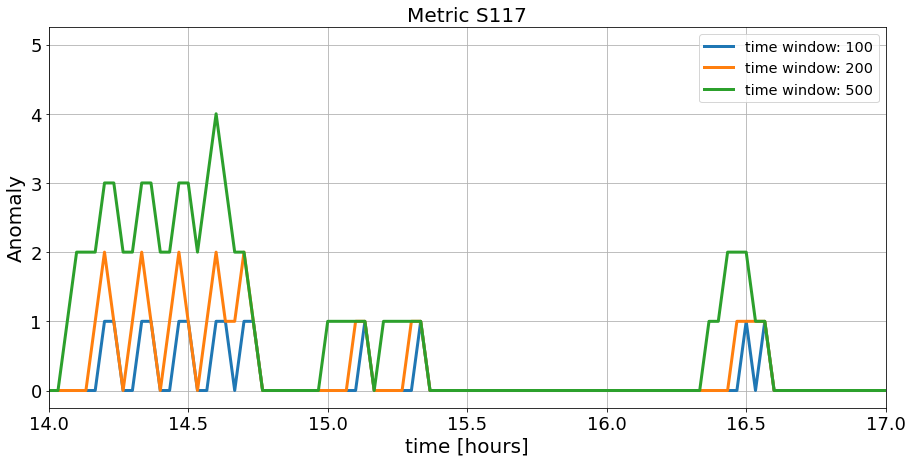

In [169]:
time_x = (anomalies_pd['epoch'] - anomalies_pd['epoch'].min())/(3600) # in hours from the beginning of the measures
plt.figure(figsize=(15,7))
plt.plot(time_x, anomalies_pd[anomaly_col[0]],lw=3, label= "time window: 100")
plt.plot(time_x, anomalies_pd2[anomaly_col[0]],lw=3, label= "time window: 200")
plt.plot(time_x, anomalies_pd3[anomaly_col[0]],lw=3, label= "time window: 500")

plt.legend(loc = "best", fontsize = 'x-large')
plt.xlabel('time [hours]', fontsize=20)
plt.ylabel('Anomaly', fontsize=20)
plt.title('Metric S117', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(14,17)
plt.grid()

## metric S118

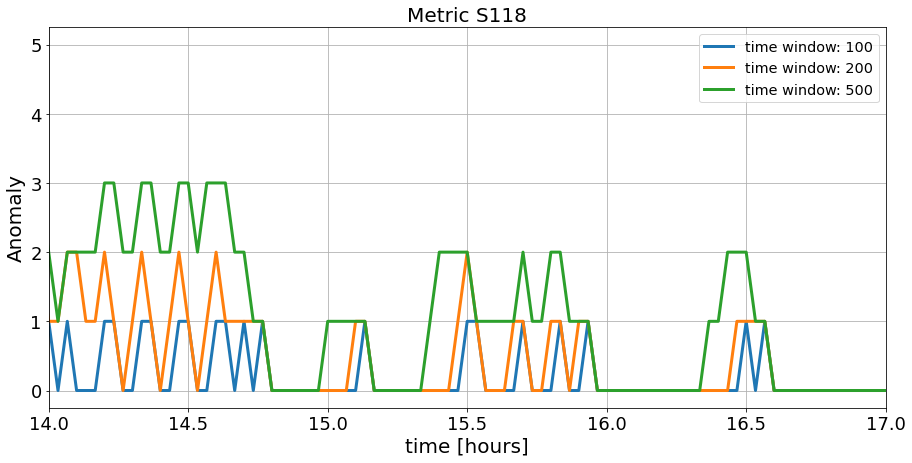

In [170]:
time_x = (anomalies_pd['epoch'] - anomalies_pd['epoch'].min())/(3600) # in hours from the beginning of the measures
plt.figure(figsize=(15,7))
plt.plot(time_x, anomalies_pd[anomaly_col[1]],lw=3, label= "time window: 100")
plt.plot(time_x, anomalies_pd2[anomaly_col[1]],lw=3, label= "time window: 200")
plt.plot(time_x, anomalies_pd3[anomaly_col[1]],lw=3, label= "time window: 500")

plt.legend(loc = "best", fontsize = 'x-large')
plt.xlabel('time [hours]', fontsize=20)
plt.ylabel('Anomaly', fontsize=20)
plt.title('Metric S118', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(14,17)
plt.grid()

## metric S169

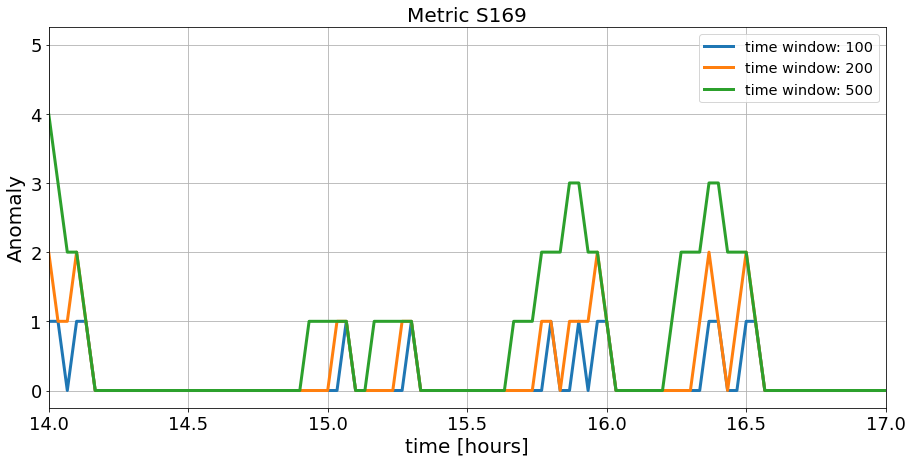

In [171]:
time_x = (anomalies_pd['epoch'] - anomalies_pd['epoch'].min())/(3600) # in hours from the beginning of the measures
plt.figure(figsize=(15,7))
plt.plot(time_x, anomalies_pd[anomaly_col[2]],lw=3, label= "time window: 100")
plt.plot(time_x, anomalies_pd2[anomaly_col[2]],lw=3, label= "time window: 200")
plt.plot(time_x, anomalies_pd3[anomaly_col[2]],lw=3, label= "time window: 500")

plt.legend(loc = "best", fontsize = 'x-large')
plt.xlabel('time [hours]', fontsize=20)
plt.ylabel('Anomaly', fontsize=20)
plt.title('Metric S169', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(14,17)
plt.grid()

## metric S170

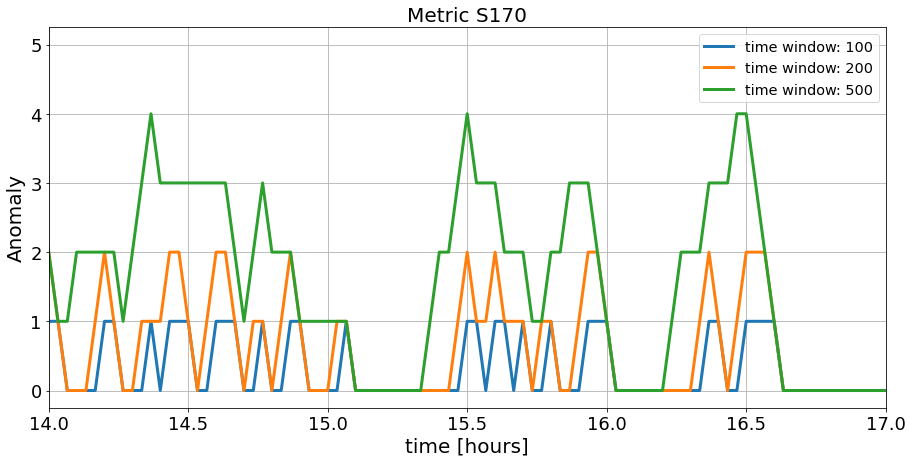

In [172]:
time_x = (anomalies_pd['epoch'] - anomalies_pd['epoch'].min())/(3600) # in hours from the beginning of the measures
plt.figure(figsize=(15,7))
plt.plot(time_x, anomalies_pd[anomaly_col[3]],lw=3, label= "time window: 100")
plt.plot(time_x, anomalies_pd2[anomaly_col[3]],lw=3, label= "time window: 200")
plt.plot(time_x, anomalies_pd3[anomaly_col[3]],lw=3, label= "time window: 500")

plt.legend(loc = "best", fontsize = 'x-large')
plt.xlabel('time [hours]', fontsize=20)
plt.ylabel('Anomaly', fontsize=20)
plt.title('Metric S170', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(14,17)
plt.grid()

In [61]:
del anomalies_pd
del anomalies_pd2
del anomalies_pd3

# Normalizing frequencies of some other metrics

In [238]:
# get all the metrics in the dataset
all_metrics = df.select('metric').distinct().collect()
all_metrics = [elem[0] for elem in all_metrics]

In [239]:
# selecting just the sensors
S_metrics = [x for x in all_metrics if x.startswith('S')]

In [240]:
# metrics related to machines being turned off and on
metrics = ['S117', 'S118', 'S169', 'S170'] 

In [241]:
# remove the previous metrics
for elem in metrics:
    S_metrics.remove(elem)

In [273]:
# select a few metrics to look for correlation with anomalies
# max corr 0:26 0.2
sample_metrics = S_metrics[26:46]

In [274]:
# normalize the frequencies of the metrics
timestep = 120 #sec
df_sample_metrics = normalize_dataframe(df, metrics_list=sample_metrics, ref_timegrid=ref_timegrid, timestep=timestep, case=1)

In [275]:
%%time
df_sample_metrics.cache().show()

22/07/11 13:39:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:39:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:39:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:39:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:39:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:39:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 1

+----------+-----+----------+------+-----+---+----+----+----+---+-----+-----+----+---+-----+-----+----+---+----+-----+----+-----+
|     epoch|  S37|part_index|  S202|  S90|S35|S157| S97|S115|SA4|   S3| S107|S110|S16|  S46| S159|S183|SA3|S165|  S47|S171| S101|
+----------+-----+----------+------+-----+---+----+----+----+---+-----+-----+----+---+-----+-----+----+---+----+-----+----+-----+
|1609510560|351.0|         0|7183.0|  0.0|0.0|82.0| 0.0| 0.0|0.0|200.0|148.0| 0.0|0.0|243.0| 83.0| 0.0|0.0| 0.0|241.0| 1.0|  0.0|
|1609525920|  0.0|         0|7200.0|  0.0|0.0|71.0| 0.0| 0.0|0.0|145.0|  0.0| 0.0|0.0|  0.0| 75.0| 0.0|0.0| 0.0|  0.0| 0.0|  0.0|
|1609544640|  0.0|         0|7200.0|  0.0|0.0|72.0| 0.0| 0.0|0.0|145.0|  0.0| 0.0|0.0|  0.0| 75.0| 0.0|0.0| 0.0|  0.0| 0.0|  0.0|
|1609545240|  0.0|         0|7200.0|  0.0|0.0|72.0| 0.0| 0.0|0.0|145.0|  0.0| 0.0|0.0|  0.0| 75.0| 0.0|0.0| 0.0|  0.0| 0.0|  0.0|
|1609545360|351.0|         0|7183.0|  0.0|0.0|80.0| 0.0| 0.0|0.0|200.0|213.0| 0.0|0.0|400.

In [246]:
df_sample_metrics.printSchema()

root
 |-- epoch: long (nullable = false)
 |-- S178: double (nullable = true)
 |-- part_index: integer (nullable = true)
 |-- S102: double (nullable = true)
 |-- S106: double (nullable = true)
 |-- S6: double (nullable = true)
 |-- S94: double (nullable = true)
 |-- S8: double (nullable = true)
 |-- SW: double (nullable = true)
 |-- S7: double (nullable = true)
 |-- S56: double (nullable = true)
 |-- SA12: double (nullable = true)
 |-- S143: double (nullable = true)
 |-- S164: double (nullable = true)
 |-- SA8: double (nullable = true)
 |-- S86: double (nullable = true)
 |-- S158: double (nullable = true)
 |-- S151: double (nullable = true)
 |-- S57: double (nullable = true)
 |-- S166: double (nullable = true)
 |-- S80: double (nullable = true)
 |-- S19: double (nullable = true)



In [276]:
# join the two normalized dataframes created before
df_ex1 = df_sample_metrics.join(df_norm1, ['epoch'], 'inner').drop(df_norm1.part_index)

In [277]:
df_ex1.cache().show()

+----------+-----+----------+------+-----+---+----+----+----+---+-----+-----+----+---+-----+-----+----+---+----+-----+----+-----+---------+---------+---------+---------+
|     epoch|  S37|part_index|  S202|  S90|S35|S157| S97|S115|SA4|   S3| S107|S110|S16|  S46| S159|S183|SA3|S165|  S47|S171| S101|anom_S117|anom_S118|anom_S169|anom_S170|
+----------+-----+----------+------+-----+---+----+----+----+---+-----+-----+----+---+-----+-----+----+---+----+-----+----+-----+---------+---------+---------+---------+
|1609510560|351.0|         0|7183.0|  0.0|0.0|82.0| 0.0| 0.0|0.0|200.0|148.0| 0.0|0.0|243.0| 83.0| 0.0|0.0| 0.0|241.0| 1.0|  0.0|      0.0|      0.0|      0.0|      0.0|
|1609525920|  0.0|         0|7200.0|  0.0|0.0|71.0| 0.0| 0.0|0.0|145.0|  0.0| 0.0|0.0|  0.0| 75.0| 0.0|0.0| 0.0|  0.0| 0.0|  0.0|      0.0|      0.0|      0.0|      0.0|
|1609544640|  0.0|         0|7200.0|  0.0|0.0|72.0| 0.0| 0.0|0.0|145.0|  0.0| 0.0|0.0|  0.0| 75.0| 0.0|0.0| 0.0|  0.0| 0.0|  0.0|      0.0|      0.0| 

22/07/11 13:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB


In [278]:
df_ex1.printSchema()

root
 |-- epoch: long (nullable = false)
 |-- S37: double (nullable = true)
 |-- part_index: integer (nullable = true)
 |-- S202: double (nullable = true)
 |-- S90: double (nullable = true)
 |-- S35: double (nullable = true)
 |-- S157: double (nullable = true)
 |-- S97: double (nullable = true)
 |-- S115: double (nullable = true)
 |-- SA4: double (nullable = true)
 |-- S3: double (nullable = true)
 |-- S107: double (nullable = true)
 |-- S110: double (nullable = true)
 |-- S16: double (nullable = true)
 |-- S46: double (nullable = true)
 |-- S159: double (nullable = true)
 |-- S183: double (nullable = true)
 |-- SA3: double (nullable = true)
 |-- S165: double (nullable = true)
 |-- S47: double (nullable = true)
 |-- S171: double (nullable = true)
 |-- S101: double (nullable = true)
 |-- anom_S117: double (nullable = true)
 |-- anom_S118: double (nullable = true)
 |-- anom_S169: double (nullable = true)
 |-- anom_S170: double (nullable = true)



# Finding correlations <a class="anchor" id="corr1"></a>

After normalizing the frequncies for some metrics we look for the correlation between our anomaly metrics and the others. We use the Pearson correlation

<p align="left">
<img src="figures/pearson.jpg"  width="300"/> </p>
<p align="left">

In [279]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [280]:
# drop column that are not metrics
df_ex1_to_correlate = df_ex1.drop('epoch', 'part_index')

df_ex1_to_correlate.show(10)

dim_corr_matrix = len(df_ex1_to_correlate.columns)

columns_correlation = df_ex1_to_correlate.columns

+-----+------+-----+---+----+----+----+---+-----+-----+----+---+-----+----+----+---+----+-----+----+-----+---------+---------+---------+---------+
|  S37|  S202|  S90|S35|S157| S97|S115|SA4|   S3| S107|S110|S16|  S46|S159|S183|SA3|S165|  S47|S171| S101|anom_S117|anom_S118|anom_S169|anom_S170|
+-----+------+-----+---+----+----+----+---+-----+-----+----+---+-----+----+----+---+----+-----+----+-----+---------+---------+---------+---------+
|351.0|7183.0|  0.0|0.0|82.0| 0.0| 0.0|0.0|200.0|148.0| 0.0|0.0|243.0|83.0| 0.0|0.0| 0.0|241.0| 1.0|  0.0|      0.0|      0.0|      0.0|      0.0|
|  0.0|7200.0|  0.0|0.0|71.0| 0.0| 0.0|0.0|145.0|  0.0| 0.0|0.0|  0.0|75.0| 0.0|0.0| 0.0|  0.0| 0.0|  0.0|      0.0|      0.0|      0.0|      0.0|
|  0.0|7200.0|  0.0|0.0|72.0| 0.0| 0.0|0.0|145.0|  0.0| 0.0|0.0|  0.0|75.0| 0.0|0.0| 0.0|  0.0| 0.0|  0.0|      0.0|      0.0|      0.0|      0.0|
|  0.0|7200.0|  0.0|0.0|72.0| 0.0| 0.0|0.0|145.0|  0.0| 0.0|0.0|  0.0|75.0| 0.0|0.0| 0.0|  0.0| 0.0|  0.0|      0.0|  

22/07/11 13:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1092.9 KiB


In [281]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_ex1_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_ex1_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)


22/07/11 13:41:52 WARN DAGScheduler: Broadcasting large task binary with size 1178.7 KiB
22/07/11 13:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1182.2 KiB
22/07/11 13:42:03 ERROR TaskSchedulerImpl: Lost executor 1 on 10.67.22.217: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/07/11 13:42:03 WARN TaskSetManager: Lost task 50.0 in stage 4127.0 (TID 120999) (10.67.22.217 executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/07/11 13:42:03 WARN TaskSetManager: Lost task 49.0 in stage 4127.0 (TID 120998) (10.67.22.217 executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or netwo

22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_367_60 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4727_15 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_1727_109 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_5591_32 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_3145_70 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_3793_70 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_637_130 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4703_187 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_637_90 !
22/07/11 13:42:04 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_3145_46 !
22/07/11 13:42:04 WARN BlockManagerMaste

22/07/11 13:42:08 WARN TaskSetManager: Lost task 55.0 in stage 4127.0 (TID 121004) (10.67.22.183 executor 0): FetchFailed(BlockManagerId(1, 10.67.22.217, 42675, None), shuffleId=621, mapIndex=51, mapId=113972, reduceId=55, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1165)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:903)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:84)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31)
	at org.apache.spark.InterruptibleIt

	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage41.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage55.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage69.processNext(Unknown Source)
	at org.apache.spark.sql.execution

	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1481)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1408)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1295)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at o

	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.ap

	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:386)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1481)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1408)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1295)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.s

	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.

	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.

	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage209.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage223.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage237.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execut

	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1481)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1408)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1295)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spar

	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:386)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1481)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1408)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1295)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapParti

	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage195.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage209.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:778)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage223.processNext(Unknown Source)
	at org.apache.spark.sql.execut

22/07/11 13:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1182.2 KiB
22/07/11 13:43:16 WARN TaskSetManager: Lost task 147.0 in stage 4127.1 (TID 125207) (10.67.22.85 executor 2): org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 28 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:158)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:118)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:401)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:420)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:455)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIt

### Plotting the Correlation Matrix

In [282]:
corr_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].values

In [283]:
corr_matrix = corr_matrix.reshape(dim_corr_matrix,dim_corr_matrix)

In [284]:
import matplotlib.pyplot as plt

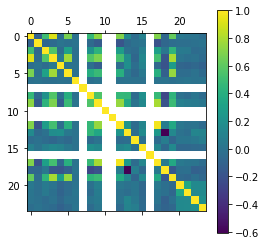

In [285]:
plt.matshow(corr_matrix)
plt.colorbar()

In [286]:
indexes = np.where(corr_matrix)

In [287]:
indexes_row = indexes[0]
indexes_col = indexes[1]

Building a dataframe to show the correlation results

In [288]:
high_corr_row = [columns_correlation[i] for i in indexes_row]
high_corr_col = [columns_correlation[i] for i in indexes_col]
correlations = [corr_matrix[i,j] for i,j in zip(indexes_row, indexes_col)]

In [289]:
import pandas as pd

In [290]:
correlation_df = pd.DataFrame({
    'metric1' : high_corr_row,
    'metric2' : high_corr_col,
    'correlation' : correlations}
)

In [291]:
correlation_df = correlation_df.dropna()
correlation_df

,metric1,metric2,correlation
0,S37,S37,1.000000
1,S37,S202,-0.107780
2,S37,S90,0.500625
3,S37,S35,0.914151
4,S37,S157,-0.026893
...,...,...,...
571,anom_S170,S101,-0.069138
572,anom_S170,anom_S117,0.152729
573,anom_S170,anom_S118,0.157170
574,anom_S170,anom_S169,0.192442


In [292]:
# get rid of trivial correlation
correlation_df = correlation_df[ correlation_df['metric1']!=correlation_df['metric2']]

array([[<AxesSubplot:title={'center':'correlation'}>]], dtype=object)

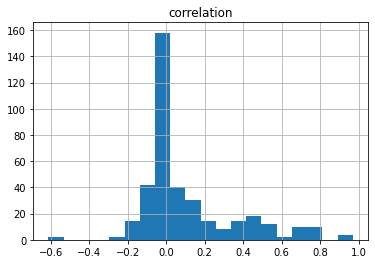

In [293]:
correlation_df.hist(bins=20)

Selecting just the correlations between anomalies and metrics

In [294]:
correlation_df = correlation_df[correlation_df['metric1'].str.startswith('a') & ~(correlation_df['metric2'].str.startswith('a'))]

In [295]:
correlation_df.sort_values(by=['correlation'], ascending=False)

,metric1,metric2,correlation
541,anom_S169,S159,0.121293
565,anom_S170,S159,0.106765
489,anom_S117,S107,0.091827
566,anom_S170,S183,0.077532
513,anom_S118,S107,0.064905
...,...,...,...
484,anom_S117,S157,-0.081563
508,anom_S118,S157,-0.090241
570,anom_S170,S171,-0.092502
556,anom_S170,S157,-0.107343


# Assignment 2: Anomaly Detection <a class="anchor" id="anomaly2"></a>

As before, the devices in the dataset have 4 different engines which have to compress a
gas to chill or heat the environment. The percentage of working/loading of those units
is extremely important due to it could indicate problems related to under-dimensioned
or over-dimensioned devices, deterioration of some mechanical parts, or not suitable
external environment conditions. For this point, the task is:

• Identify some possible correlations between the percentage of device loading and
the external temperature
The metrics/variables that contain the information about the loading percentage of the
devices are:

• S125 (ergated capacity by circuit 1)

• S181 (ergated capacity by circuit 2)

A device can have one or both variables.


In [296]:
perc_metric = ['S125', 'S181']   #loading percentage metrics
temp_metric = ['S41']  #the external temperature metric 

metrics = ['S125', 'S181', 'S41'] #set of used metrics

timestep = 120 #global time interval in seconds

Finding the refrence time grid calling the function

In [297]:
ref_timegrid = get_reference_timegrid(df=df, ref_metrics=metrics, timestep=timestep)

22/07/11 13:46:24 WARN CacheManager: Asked to cache already cached data.        


In [298]:
%%time
# define partitions over time to parallelize more the frequence normalization of the metrics
minimum = ref_timegrid.agg(min("epoch")).collect()[0][0]
partition_length = 7 * 24 * 60 * 60 #sec

# define partition index
ref_timegrid = ref_timegrid.sort('epoch').withColumn('part_index', ((col('epoch')-lit(minimum))/(partition_length)).cast('int'))

CPU times: user 9.31 ms, sys: 459 µs, total: 9.77 ms
Wall time: 351 ms


Normalizing the frequecies of the seleced metrics

In [302]:
df_ex2 = normalize_dataframe(df, metrics_list=metrics, ref_timegrid=ref_timegrid, timestep=timestep, case=1)

In [303]:
df_ex2.printSchema()

root
 |-- epoch: long (nullable = false)
 |-- S125: double (nullable = true)
 |-- part_index: integer (nullable = true)
 |-- S181: double (nullable = true)
 |-- S41: double (nullable = true)



In [304]:
df_ex2.cache().count()

22/07/11 13:48:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:48:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 13:48:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


64770

Finding the correlation 

In [306]:
# drop column that are not metrics
df_ex2_to_correlate = df_ex2.drop('epoch', 'part_index')

df_ex2_to_correlate.show(10)

dim_corr_matrix = len(df_ex2_to_correlate.columns)

columns_correlation = df_ex2_to_correlate.columns

+----+----+-----+
|S125|S181|  S41|
+----+----+-----+
| 0.0| 0.0| 48.0|
| 0.0| 0.0| 12.0|
| 0.0| 0.0| 15.0|
| 0.0| 0.0| 15.0|
| 0.0| 0.0| 41.0|
| 0.0| 0.0| 31.0|
| 0.0| 0.0| 25.0|
| 0.0| 0.0| 31.0|
| 0.0| 0.0| 31.0|
| 0.0| 0.0|108.0|
+----+----+-----+
only showing top 10 rows



In [307]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_ex2_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_ex2_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [308]:
corr_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].values

In [309]:
corr_matrix = corr_matrix.reshape(dim_corr_matrix,dim_corr_matrix)

In [310]:
import matplotlib.pyplot as plt

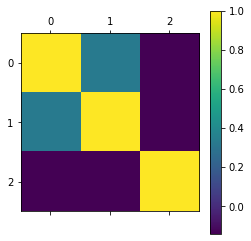

In [311]:
plt.matshow(corr_matrix)
plt.colorbar()

In [312]:
indexes = np.where(corr_matrix)

In [313]:
indexes_row = indexes[0]
indexes_col = indexes[1]

In [314]:
high_corr_row = [columns_correlation[i] for i in indexes_row]
high_corr_col = [columns_correlation[i] for i in indexes_col]
correlations = [corr_matrix[i,j] for i,j in zip(indexes_row, indexes_col)]

In [315]:
import pandas as pd

In [316]:
correlation_df = pd.DataFrame({
    'metric1' : high_corr_row,
    'metric2' : high_corr_col,
    'correlation' : correlations}
)

In [317]:
# get rid of trivial correlation
correlation_df = correlation_df[ correlation_df['metric1']!=correlation_df['metric2']]

array([[<AxesSubplot:title={'center':'correlation'}>]], dtype=object)

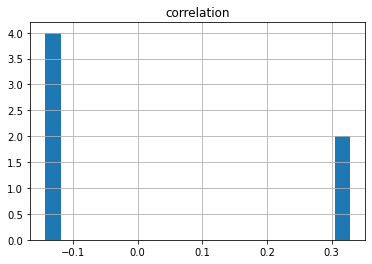

In [318]:
correlation_df.hist(bins=20)

In [319]:
correlation_df = correlation_df[correlation_df['metric1'].str.startswith('S41') & ~(correlation_df['metric2'].str.startswith('S41'))]

In [320]:
correlation_df.sort_values(by=['correlation'], ascending=False)

,metric1,metric2,correlation
6,S41,S125,-0.138503
7,S41,S181,-0.142659


# Assignment 3: Predictive Maintenace <a class="anchor" id="predmain"></a>

As written in the previous section, variables A5 and A9 contain alarms about the devices.
More specifically, if one (or all) of the bit in positions 6, 7, and 8, of one/both the alarm/s,
are equal to 1 this means that there is/are one/some faulty/ies. In fact, if at least one of
the cited bits is at 1, it means the engines are overheating.
For this point the task is:

• Convert the alarms from their integer encoding to their bit string and then identify correctly the required alarms

• Once the alarms have been identified find some possible correlation between the variables and those alarms.

• With the figured out correlations, try to predict an alarm in the future. E.g: given
a set of correlated features (variable) at time T i−1 try to predict if at time T i there
will a fault or not.
The metrics/variables that contain the information about the alarms are:

• A5
• A9


In [18]:
alarm_metric = ['A5', 'A9']
# choosing among metrics related to temperatures
metrics = ['A5', 'A9', 'S40', 'S39', 'S41', 'S3', 'S109', 'S107']

timestep = 120 #sec

In [22]:
ref_timegrid = get_reference_timegrid(df=df, ref_metrics=alarm_metric, timestep=timestep)
# define partitions over time to parallelize more the frequence normalization of the metrics
minimum = ref_timegrid.agg(min("epoch")).collect()[0][0]
partition_length = 7 * 24 * 60 * 60 #sec # one week

# define partition index
ref_timegrid = ref_timegrid.sort('epoch').withColumn('part_index', ((col('epoch')-lit(minimum))/(partition_length)).cast('int'))

22/07/11 16:02:19 WARN CacheManager: Asked to cache already cached data.


In [23]:
df_ex3 = normalize_dataframe(df, metrics_list=metrics,ref_timegrid=ref_timegrid, timestep=timestep, case=1)

In [24]:
df_ex3.cache().show()

22/07/11 16:02:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 16:02:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 16:02:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 16:02:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 16:02:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 16:02:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/11 1

+----------+---+----------+---+-----+-----+-----+-----+-----+-----+
|     epoch| A5|part_index| A9|  S40|  S39|  S41|   S3| S109| S107|
+----------+---+----------+---+-----+-----+-----+-----+-----+-----+
|1609510560|0.0|         0|0.0|143.0|142.0| 48.0|200.0| 72.0|148.0|
|1609525920|0.0|         0|0.0|122.0|123.0| 12.0|145.0| 83.0|  0.0|
|1609544640|0.0|         0|0.0|124.0|125.0| 15.0|145.0| 84.0|  0.0|
|1609545240|0.0|         0|0.0|124.0|125.0| 15.0|145.0| 86.0|  0.0|
|1609545360|0.0|         0|0.0|243.0|243.0| 41.0|200.0| 70.0|213.0|
|1609583400|0.0|         0|0.0|119.0|117.0| 31.0|200.0| 56.0|141.0|
|1609611720|0.0|         0|0.0|125.0|126.0| 25.0|145.0| 98.0|  0.0|
|1609651920|0.0|         0|0.0|124.0|125.0| 31.0|145.0|111.0|  0.0|
|1609662600|0.0|         0|0.0|143.0|142.0| 31.0|200.0| 56.0|128.0|
|1609679640|0.0|         0|0.0|150.0|150.0|108.0|151.0|252.0|340.0|
|1609691520|0.0|         0|0.0|146.0|144.0| 34.0|200.0| 61.0|127.0|
|1609741080|0.0|         0|0.0|174.0|174.0| 55.0

## Mapping A5 and A9 Metrics to String of 16 bit

In [25]:
from pyspark.sql.types import StringType

In [26]:
map_to_16bit = udf(lambda x: '{0:016b}'.format(int(x)), StringType())

In [27]:
anomaly_col = df_ex3.columns
anomaly_col.remove('part_index')
anomaly_col.remove('epoch')

In [28]:
anomaly_col

['A5', 'A9', 'S40', 'S39', 'S41', 'S3', 'S109', 'S107']

subsituting the alarm metrics with corresponding 16 bits strings

In [29]:
for col_name in alarm_metric:
    df_ex3 = df_ex3.withColumn(col_name,map_to_16bit(col(col_name)))

In [30]:
df_ex3.cache().show()

+----------+----------------+----------+----------------+-----+-----+-----+-----+-----+-----+
|     epoch|              A5|part_index|              A9|  S40|  S39|  S41|   S3| S109| S107|
+----------+----------------+----------+----------------+-----+-----+-----+-----+-----+-----+
|1609510560|0000000000000000|         0|0000000000000000|143.0|142.0| 48.0|200.0| 72.0|148.0|
|1609525920|0000000000000000|         0|0000000000000000|122.0|123.0| 12.0|145.0| 83.0|  0.0|
|1609544640|0000000000000000|         0|0000000000000000|124.0|125.0| 15.0|145.0| 84.0|  0.0|
|1609545240|0000000000000000|         0|0000000000000000|124.0|125.0| 15.0|145.0| 86.0|  0.0|
|1609545360|0000000000000000|         0|0000000000000000|243.0|243.0| 41.0|200.0| 70.0|213.0|
|1609583400|0000000000000000|         0|0000000000000000|119.0|117.0| 31.0|200.0| 56.0|141.0|
|1609611720|0000000000000000|         0|0000000000000000|125.0|126.0| 25.0|145.0| 98.0|  0.0|
|1609651920|0000000000000000|         0|0000000000000000|124



## Cutting string of 16bit in meaningfull places, i.e. bits 6 , 7 and 8. map directly to label 1 if either one of the 3 is 1. To label 0 otherwise.

In [31]:
from pyspark.sql.types import IntegerType

In [32]:
cut_b = udf(lambda x:  int(x[5] or x[6] or x[7]), IntegerType())

In [33]:
for col_name in alarm_metric:
    df_ex3 = df_ex3.withColumn(col_name,cut_b(col(col_name)))


In [34]:
df_ex3.cache().show()

+----------+---+----------+---+-----+-----+-----+-----+-----+-----+
|     epoch| A5|part_index| A9|  S40|  S39|  S41|   S3| S109| S107|
+----------+---+----------+---+-----+-----+-----+-----+-----+-----+
|1609510560|  0|         0|  0|143.0|142.0| 48.0|200.0| 72.0|148.0|
|1609525920|  0|         0|  0|122.0|123.0| 12.0|145.0| 83.0|  0.0|
|1609544640|  0|         0|  0|124.0|125.0| 15.0|145.0| 84.0|  0.0|
|1609545240|  0|         0|  0|124.0|125.0| 15.0|145.0| 86.0|  0.0|
|1609545360|  0|         0|  0|243.0|243.0| 41.0|200.0| 70.0|213.0|
|1609583400|  0|         0|  0|119.0|117.0| 31.0|200.0| 56.0|141.0|
|1609611720|  0|         0|  0|125.0|126.0| 25.0|145.0| 98.0|  0.0|
|1609651920|  0|         0|  0|124.0|125.0| 31.0|145.0|111.0|  0.0|
|1609662600|  0|         0|  0|143.0|142.0| 31.0|200.0| 56.0|128.0|
|1609679640|  0|         0|  0|150.0|150.0|108.0|151.0|252.0|340.0|
|1609691520|  0|         0|  0|146.0|144.0| 34.0|200.0| 61.0|127.0|
|1609741080|  0|         0|  0|174.0|174.0| 55.0

joining the two alarms into one metric 'A'


## Random Forest <a class="anchor" id="forest"></a>

We would like to try to implement a random forest classifier to predict weather the alarm is going to happen at later time or not. But because of the sparsity of data it would not be a meaningful approch

<p align="left">
<img src="figures/forest.png"  width="600"/> </p>
<p align="left">

In [76]:
import numpy
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

In [77]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [78]:
# data = df_ex3_shift.drop('A9_tot','A5_tot', 'A9_shift', 'index')
data = df_ex3_shift.drop('A9_tot','A5_tot', 'A9_shift', 'index')

In [79]:
data.cache().show()

22/07/08 15:49:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:49:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1210.8 KiB
22/07/08 15:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1258.3 KiB


+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+
|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_shift|
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+
|     137.0|     103.0|      75.0|     151.0|     152.0|     103.0|     100.0|     150.0|     183.0|     177.0|     232.0|     152.0|    145.0|    125.0|     91.0|

In [80]:
from pyspark.ml.feature import VectorAssembler

numericCols = data.columns[:-1]
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
data = assembler.transform(data)
data.show()

+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+--------------------+
|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_shift|            features|
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+--------------------+
|     137.0|     103.0|      75.0|     151.0|     152.0|     103.0|     100.0|     150.0|     183.0|

22/07/08 15:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1276.5 KiB


In [81]:
from pyspark.ml.feature import StringIndexer

label_stringIdx = StringIndexer(inputCol = 'A5_shift', outputCol = 'labelIndex')
data = label_stringIdx.fit(data).transform(data)
data.show()

22/07/08 15:49:18 WARN DAGScheduler: Broadcasting large task binary with size 1247.0 KiB


+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+--------------------+----------+
|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_shift|            features|labelIndex|
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+--------------------+----------+
|     137.0|     103.0|      75.0|     151.0|     152.0|     103.0|

22/07/08 15:49:19 WARN DAGScheduler: Broadcasting large task binary with size 1285.8 KiB


In [82]:
train, test = data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

22/07/08 15:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1294.4 KiB


Training Dataset Count: 20222


22/07/08 15:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1294.4 KiB


Test Dataset Count: 8629


In [83]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'labelIndex')
rfModel = rf.fit(train)

22/07/08 15:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1303.0 KiB
22/07/08 15:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1303.1 KiB
22/07/08 15:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1308.1 KiB
22/07/08 15:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1313.2 KiB


In [84]:
predictions = rfModel.transform(test)
# predictions.select('sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'labelIndex', 'rawPrediction', 'prediction', 'probability').show(25)

In [85]:
predictions.select('rawPrediction', 'probability', 'prediction','A5_shift').show()

22/07/08 15:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1361.3 KiB


+-------------+-----------+----------+--------+
|rawPrediction|probability|prediction|A5_shift|
+-------------+-----------+----------+--------+
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|  

In [86]:
predictions.groupBy('A5_shift').count().show()

22/07/08 15:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB


+--------+-----+
|A5_shift|count|
+--------+-----+
|       0| 8629|
+--------+-----+



In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

22/07/08 14:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1390.1 KiB


Accuracy = 1.0
Test Error = 0.0


## Rolling Correlation over Time

We assume that when approching the alarm time the average correlation of some metrics must vary over time. For this purpose we consider correlation on rolling windows for differnet metrics and then take the average over those metrics

<p align="left">
<img src="figures/ex_3.png"  width="650"/> </p>
<p align="left">

In [35]:
df_ex3 = df_ex3.withColumn('A', (col('A5').cast('boolean') | col('A9').cast('boolean')).cast('int')).drop('')

In [36]:
df_ex3 = df_ex3.drop('A5', 'A9')
df_ex3.cache().show()

+----------+----------+-----+-----+-----+-----+-----+-----+---+
|     epoch|part_index|  S40|  S39|  S41|   S3| S109| S107|  A|
+----------+----------+-----+-----+-----+-----+-----+-----+---+
|1609510560|         0|143.0|142.0| 48.0|200.0| 72.0|148.0|  0|
|1609525920|         0|122.0|123.0| 12.0|145.0| 83.0|  0.0|  0|
|1609544640|         0|124.0|125.0| 15.0|145.0| 84.0|  0.0|  0|
|1609545240|         0|124.0|125.0| 15.0|145.0| 86.0|  0.0|  0|
|1609545360|         0|243.0|243.0| 41.0|200.0| 70.0|213.0|  0|
|1609583400|         0|119.0|117.0| 31.0|200.0| 56.0|141.0|  0|
|1609611720|         0|125.0|126.0| 25.0|145.0| 98.0|  0.0|  0|
|1609651920|         0|124.0|125.0| 31.0|145.0|111.0|  0.0|  0|
|1609662600|         0|143.0|142.0| 31.0|200.0| 56.0|128.0|  0|
|1609679640|         0|150.0|150.0|108.0|151.0|252.0|340.0|  0|
|1609691520|         0|146.0|144.0| 34.0|200.0| 61.0|127.0|  0|
|1609741080|         0|174.0|174.0| 55.0|151.0|956.0|503.0|  0|
|1609752960|         0|127.0|128.0| 45.0

Retreiving the epochs where alarms happen 

In [268]:
anom_epochs = df_ex3.where(df_ex3.A == 1).select('epoch').collect()
anom_epochs = [epoch[0] for epoch in anom_epochs]
anom_epochs

[1612825560, 1612845960, 1612814640, 1612854600, 1612854480, 1612814760]

Defining the partitioning indeces around every alarm epoch

In [38]:
df_anom = []
i = 0
for epoch in anom_epochs:
    
    start_time = epoch - 100 * timestep
    end_time =   epoch + 100 * timestep
    
    df_anom.append(df_ex3.filter( (df_ex3.epoch > start_time) & (df_ex3.epoch < end_time))\
                                .withColumn('alarm_num', lit(i)))
    i+=1                                                                     

In [40]:
# union 
df_trimmed = df_anom[0]

#stacking all the dataframes realted to different alarms into one dataframe
for df in df_anom:
    df_trimmed = df_trimmed.union(df)

In [41]:
df_trimmed.cache().show()

+----------+----------+-----+-----+-----+-----+-----+-----+---+---------+
|     epoch|part_index|  S40|  S39|  S41|   S3| S109| S107|  A|alarm_num|
+----------+----------+-----+-----+-----+-----+-----+-----+---+---------+
|1612835520|         5|320.0|320.0|136.0|300.0|387.0|400.0|  0|        0|
|1612820520|         5|119.0|117.0|-78.0|201.0|704.0|296.0|  0|        0|
|1612833360|         5|137.0|128.0|-79.0|200.0|259.0|318.0|  0|        0|
|1612813680|         5|116.0|124.0|-70.0|201.0|559.0|349.0|  0|        0|
|1612832040|         5|312.0|312.0|143.0|300.0|387.0|400.0|  0|        0|
|1612831200|         5|312.0|312.0|136.0|300.0|387.0|400.0|  0|        0|
|1612834200|         5|122.0|121.0|-79.0|200.0|704.0|341.0|  0|        0|
|1612821000|         5|295.0|295.0|158.0|300.0|384.0|397.0|  0|        0|
|1612826160|         5|106.0|118.0|-83.0|201.0|273.0|263.0|  0|        0|
|1612828080|         5|307.0|307.0|147.0|300.0|387.0|400.0|  0|        0|
|1612825560|         5|128.0|127.0|-82

In [42]:
#dropping unnecessary columns
col_to_corr = df_trimmed.columns
col_to_corr.remove('epoch')
col_to_corr.remove('part_index')
col_to_corr.remove('A')
col_to_corr.remove('alarm_num')
col_to_corr

['S40', 'S39', 'S41', 'S3', 'S109', 'S107']

Defining the columns of correlation of all the couples of metrics 

In [104]:
# create correlation over time window
from itertools import combinations

df_trimmed_corr = df_trimmed
roll_window = 40

for col_couple in combinations(col_to_corr, 2):
    col_name = 'corr_' + col_couple[0] + '_' + col_couple[1]
    df_trimmed_corr = df_trimmed_corr.withColumn(col_name, corr(col_couple[0], col_couple[1])\
                    .over(Window.partitionBy("alarm_num").orderBy("epoch")\
                          .rowsBetween(Window.currentRow,roll_window)))

In [105]:
df_trimmed_corr.cache().show()

+----------+----------+-----+-----+-----+-----+-----+-----+---+---------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+
|     epoch|part_index|  S40|  S39|  S41|   S3| S109| S107|  A|alarm_num|      corr_S40_S39|      corr_S40_S41|       corr_S40_S3|      corr_S40_S109|       corr_S40_S107|      corr_S39_S41|       corr_S39_S3|      corr_S39_S109|       corr_S39_S107|       corr_S41_S3|      corr_S41_S109|       corr_S41_S107|       corr_S3_S109|        corr_S3_S107|      corr_S109_S107|
+----------+----------+-----+-----+-----+-----+-----+-----+---+---------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+-------------------+--------------------+----

Converting the dataframe to a pandas dataframe

In [384]:
corr_over_time = df_trimmed_corr.toPandas()
corr_over_time.head(5)

,epoch,part_index,S40,S39,S41,S3,S109,S107,A,alarm_num,...,corr_S39_S41,corr_S39_S3,corr_S39_S109,corr_S39_S107,corr_S41_S3,corr_S41_S109,corr_S41_S107,corr_S3_S109,corr_S3_S107,corr_S109_S107
0,1612834080,5,115.0,113.0,-79.0,200.0,564.0,347.0,0,1,...,0.997760,0.998199,-0.902191,0.693147,0.999684,-0.910685,0.654871,-0.909273,0.658575,-0.402318
1,1612834200,5,122.0,121.0,-79.0,200.0,704.0,341.0,0,1,...,0.998144,0.998454,-0.927487,0.661735,0.999646,-0.929697,0.628075,-0.929046,0.630898,-0.430655
2,1612834320,5,125.0,124.0,-80.0,200.0,768.0,365.0,0,1,...,0.998226,0.998439,-0.931907,0.640357,0.999603,-0.932138,0.608270,-0.931909,0.609149,-0.422050
3,1612834440,5,123.0,122.0,-80.0,200.0,811.0,379.0,0,1,...,0.998192,0.998347,-0.930407,0.588908,0.999567,-0.929760,0.556552,-0.929688,0.556444,-0.365470
4,1612834560,5,126.0,124.0,-82.0,200.0,822.0,381.0,0,1,...,0.998281,0.998329,-0.925393,0.538836,0.999522,-0.924025,0.506466,-0.924019,0.505772,-0.303923


In [431]:
one_alarm = corr_over_time[corr_over_time['alarm_num'] == 1] #choosing the alarm 1
one_alarm.head(5)

,epoch,part_index,S40,S39,S41,S3,S109,S107,A,alarm_num,...,corr_S39_S41,corr_S39_S3,corr_S39_S109,corr_S39_S107,corr_S41_S3,corr_S41_S109,corr_S41_S107,corr_S3_S109,corr_S3_S107,corr_S109_S107
0,1612834080,5,115.0,113.0,-79.0,200.0,564.0,347.0,0,1,...,0.997760,0.998199,-0.902191,0.693147,0.999684,-0.910685,0.654871,-0.909273,0.658575,-0.402318
1,1612834200,5,122.0,121.0,-79.0,200.0,704.0,341.0,0,1,...,0.998144,0.998454,-0.927487,0.661735,0.999646,-0.929697,0.628075,-0.929046,0.630898,-0.430655
2,1612834320,5,125.0,124.0,-80.0,200.0,768.0,365.0,0,1,...,0.998226,0.998439,-0.931907,0.640357,0.999603,-0.932138,0.608270,-0.931909,0.609149,-0.422050
3,1612834440,5,123.0,122.0,-80.0,200.0,811.0,379.0,0,1,...,0.998192,0.998347,-0.930407,0.588908,0.999567,-0.929760,0.556552,-0.929688,0.556444,-0.365470
4,1612834560,5,126.0,124.0,-82.0,200.0,822.0,381.0,0,1,...,0.998281,0.998329,-0.925393,0.538836,0.999522,-0.924025,0.506466,-0.924019,0.505772,-0.303923


In [451]:
# one alarm
col_corr_time = list(one_alarm.columns)
col_corr_time = [col for col in col_corr_time if col.startswith('corr')]
col_corr_time.append('epoch')

Finding the correaltion for a specific alarm

In [452]:
correlations_one = one_alarm[col_corr_time]
correlations_one.head(5)

,corr_S40_S39,corr_S40_S41,corr_S40_S3,corr_S40_S109,corr_S40_S107,corr_S39_S41,corr_S39_S3,corr_S39_S109,corr_S39_S107,corr_S41_S3,corr_S41_S109,corr_S41_S107,corr_S3_S109,corr_S3_S107,corr_S109_S107,epoch
0,0.999839,0.997278,0.997667,-0.906385,0.692513,0.997760,0.998199,-0.902191,0.693147,0.999684,-0.910685,0.654871,-0.909273,0.658575,-0.402318,1612834080
1,0.999826,0.997636,0.997897,-0.931902,0.660897,0.998144,0.998454,-0.927487,0.661735,0.999646,-0.929697,0.628075,-0.929046,0.630898,-0.430655,1612834200
2,0.999813,0.997728,0.997880,-0.936817,0.637960,0.998226,0.998439,-0.931907,0.640357,0.999603,-0.932138,0.608270,-0.931909,0.609149,-0.422050,1612834320
3,0.999798,0.997696,0.997775,-0.935855,0.585245,0.998192,0.998347,-0.930407,0.588908,0.999567,-0.929760,0.556552,-0.929688,0.556444,-0.365470,1612834440
4,0.999779,0.997813,0.997763,-0.931535,0.534333,0.998281,0.998329,-0.925393,0.538836,0.999522,-0.924025,0.506466,-0.924019,0.505772,-0.303923,1612834560


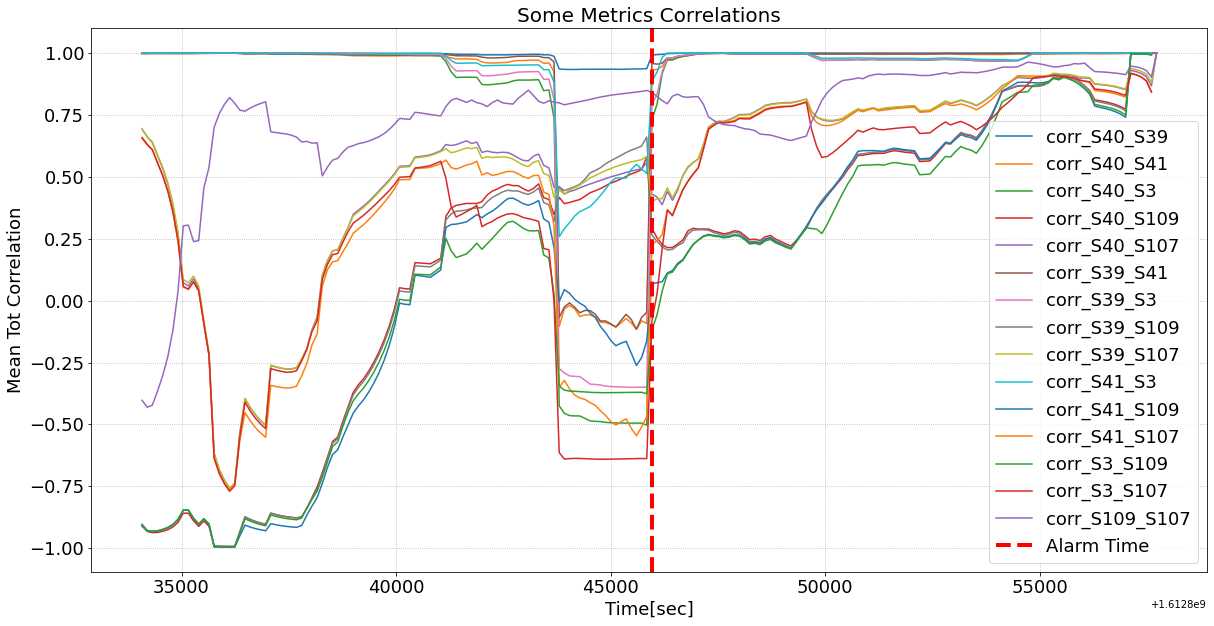

In [453]:
correlations_one.plot(x='epoch', y=col_corr_time[:-1], figsize=(20,10))
plt.axvline(x = anom_epochs[1],ls='--',lw=4, color='red', label = 'Alarm Time')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('Some Metrics Correlations', fontsize=20)
plt.ylabel('Mean Tot Correlation', fontsize=18)
plt.xlabel('Time[sec]', fontsize=18)
plt.grid(ls="dotted")

Averaging over the metrics

In [440]:
epoch_one = correlations_one['epoch']

correlations_one = correlations_one.drop(['epoch'], axis = 1)

correlations_one['tot_corr'] = correlations_one.mean(axis = 1, skipna = True)

indeces = np.arange(0,len(epoch_one))
alarm_index = np.where(epoch_one==anom_epochs[1])[0][0]

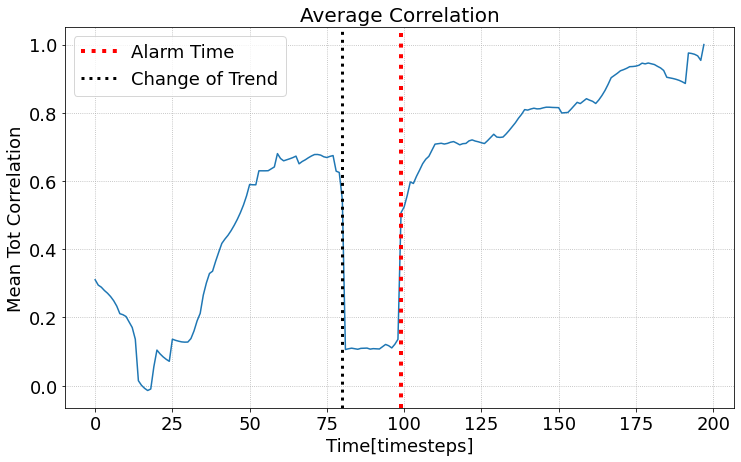

In [448]:
# look for the prediction interval
plt.figure(figsize=(12, 7))
plt.plot(indeces, correlations_one['tot_corr'])
plt.axvline(x = indeces[alarm_index],ls=':',lw=4, color='red', label = 'Alarm Time')
plt.axvline(x = 80,ls=':',lw=3, color='black', label = 'Change of Trend')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('Average Correlation', fontsize=20)
plt.ylabel('Mean Tot Correlation', fontsize=18)
plt.xlabel('Time[timesteps]', fontsize=18)
plt.grid(ls="dotted")

Plotting the average correaltion over the whole dataset 

In [444]:
corr_over_time= corr_over_time.sort_values('epoch')

In [445]:
Epoch = corr_over_time['epoch']
all_corr = corr_over_time.drop(['part_index','alarm_num','A','S40','S39','S41','S107','S109','S3','epoch'],
                               axis =1)

In [446]:
all_corr['tot_corr'] = all_corr.mean(axis = 1, skipna = True)

Text(0.5, 1.0, 'Average Correlations along All the Alarms')

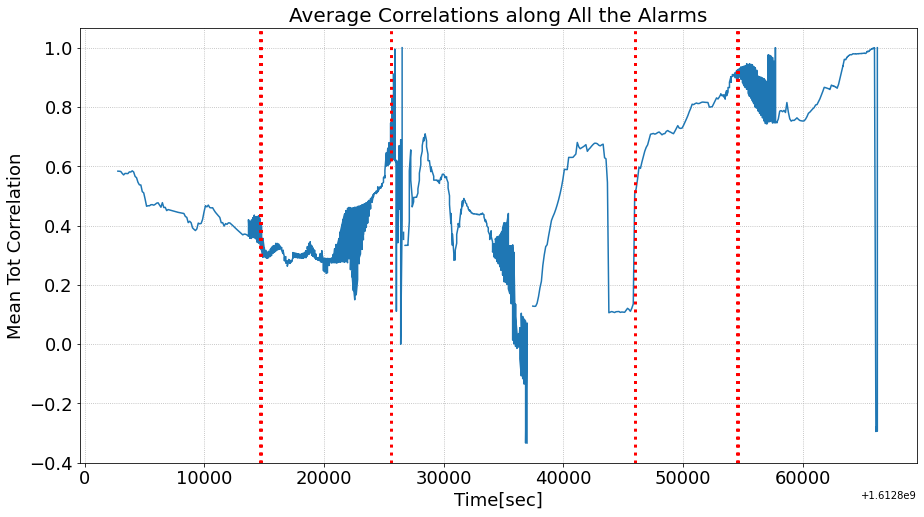

In [449]:
plt.figure(figsize=(15, 8))
plt.plot(Epoch , all_corr['tot_corr'])

plt.axvline(x = x0[0],ls=':',lw=3, color='red', label = 'axvline - full height')
plt.axvline(x = x1[0],ls=':',lw=3, color='red', label = 'axvline - full height')
plt.axvline(x = x2[0],ls=':',lw=3, color='red', label = 'axvline - full height')
plt.axvline(x = x3[0],ls=':',lw=3, color='red', label = 'axvline - full height')
plt.axvline(x = x4[0],ls=':',lw=3, color='red', label = 'axvline - full height')
plt.axvline(x = x5[0],ls=':',lw=3, color='red', label = 'axvline - full height')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Mean Tot Correlation', fontsize=18)
plt.xlabel('Time[sec]', fontsize=18)
plt.grid(ls="dotted")
plt.title('Average Correlations along All the Alarms', fontsize=20)



# Conclusion  <a class="anchor" id="conc"></a>

We tried to analyze a dataset using Apache Spark running on virtual machines. We started with normalizing the frequencies, then tried to find possible correlation between different metrics and a defined anomaly metric. And at the last part we tried to define a meaningful metrics to perdict failure of the system.